# Astro Query  ReACT Agent

#### Using Langchain Agent Library

In [1]:
%pip install langchain-openai langchain pyvo astroquery astropy Pillow


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [87]:
import datetime
import json
import os
import re

import dotenv
import httpx
import numpy as np
import openai
import tiktoken
from PIL import Image
from astropy import coordinates as coords, units as u
from astroquery.sdss import SDSS
from astroquery.simbad import Simbad
from astroquery.skyview import SkyView
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from typing import List, Union

import utils
from langchain import LLMChain, OpenAI
from langchain.agents import (
    AgentExecutor,
    AgentOutputParser,
    LLMSingleActionAgent,
    Tool,
)
from langchain.chat_models import ChatOpenAI
from langchain import PromptTemplate
from langchain.embeddings import OpenAIEmbeddings
from langchain.llms import OpenAI
from langchain.prompts import BaseChatPromptTemplate
from langchain.schema import AgentAction, AgentFinish, HumanMessage
from langchain.tools import BaseTool

from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive
from astroquery import nasa_ads as na
na.ADS.TOKEN = 'LTKDHGapR30S4S12N2EmhD1JVx2rWFMblJZcLMdR'

import pprint
pprint = pprint.PrettyPrinter(indent=4, width=120, depth=2)

#dotenv
dotenv.load_dotenv()



True

## ReACT Agent

The ReACT agent model refers to a framework that integrates the reasoning capabilities of large language models (LLMs) with the ability to take actionable steps, creating a more sophisticated system that can understand and process information, evaluate situations, take appropriate actions, communicate responses, and track ongoing situations.

The main components of the ReACT agent are:
- Chain of Thought - ReACT Prompt
- Tools for LLMs to use - ReACT Actions
- Helper functions to control and route the Agent's actions - ReACT Controllers

## Prompts

In [88]:
#react template
astro_template = """
Decode the following Astronomy query using given tools as best you can.
The query will involve a search for astronomical objects in a specific region of the sky, drawing the region, or finding data about a specific astronomical object using bibcode.
You have access to the following tools:

{tools}

Use the following format:

Query: the input question you must answer
Thought: you should always think about what to do. If the Query is not a valid astromonical data query, Provide Final Answer asking the user to provide the correct query. Any other question to the user will need to be given as Final Answer.
Action: the action to take, should be one of [{tool_names}].
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Final Answer: I now have finished 

Begin Loop:

Query: {input}
{agent_scratchpad}"""


datetime_template = """
            convert time string: {datetime} into start and end datetime formatted as: 'temporal[]=yyyy-MM-ddTHH:mm:ssZ,yyyy-MM-ddTHH:mm:ssZ'
            """


## Tools

External Tools used:

- Datetime identifier and formatting
- Keyword extraction
- geo-location extraction
- Bounding Box formatting for geo-location
- CMR API formatting

In [89]:
class DatetimeChain(LLMChain):
    """Find datetime for a given time string"""

    def __init__(self, *args, **kwargs):
        today = datetime.date.today()
        today_string = (
            f"Assume the current year and month is {today.year} and {today.month}."
        )
        template = datetime_template.strip() + today_string
        prompt = PromptTemplate(
            template=template,
            input_variables=["datetime"],
        )
        super().__init__(prompt=prompt, llm=OpenAI(temperature=0), *args, **kwargs)

    def _run(self, timestring: str) -> str:
        """Find datetime for a given time string"""
        return self.predict(datetime=timestring)

    async def _arun(self, timestring: str) -> str:
        """asynchronous call to find datetime for a given time string"""
        return self.predict(datetime=timestring)


def get_skycoords_from_text(text: str) -> str:
    """Converts a string representing a celestial object to its coordinates.

    Args:
        text (str): The string to convert to coordinates.

    Returns:
        str: The coordinates of the celestial object.
    """
    try:
        coord = SkyCoord.from_name(text)
        return coord.to_string('hmsdms')
    except Exception as e:
        return f"Invalid input:, {e}"

def query_simbad_object(coord: str, radius: str=2*u.arcminute) -> str:
    """Query the SIMBAD database for an astronomical object.

    Args:
        RA (str): The right ascension of the object.
        DEC (str): The declination of the object.
        radius (str): The radius of the search area. default is 2*u.arcminute.
        object_type (str): The type of object to search for.

    Returns:
        str: The result of the query.
    """
    simbad = Simbad()
    RA, DEC = coord.split(' ')
    try:
        result = simbad.query_region(
            coords.SkyCoord(RA, DEC, frame='icrs'),
            radius=radius,
        )
        # print the first 10 results
        result.pprint(max_width=100)
        return result
    except Exception as e:
        return f"Invalid input:, {e}"

def draw_image_from_coords(coord: str, radius: str=2*u.arcminute) -> str:
    """Draw an image of the sky around a given set of coordinates.

    Args:
        RA (str): The right ascension of the object.
        DEC (str): The declination of the object.
        radius (str): The radius of the search area. default is 2*u.arcminute.

    Returns:
        str: The path to the image file.
    """
    try:
        ra, dec = coord.split(' ')
        position = SkyCoord(ra, dec, frame='icrs', unit=(u.hourangle, u.deg))

        # Fetch the image
        images = SkyView.get_images(position=position, survey='DSS', radius=0.1 * u.deg)

        image_data = images[0][0].data

        plt.figure(figsize=(8, 8))
        plt.imshow(image_data, cmap='gray', origin='lower')
        plt.xlabel('RA')
        plt.ylabel('DEC')
        plt.title('Image')
        plt.colorbar(label='Flux')
        plt.show()

        return "Image Plotted"
    except Exception as e:
        return f"Invalid input:, {e}"

def search_docs_with_bibcode(bibcode: str) -> str:
    """Search for documents with a given bibcode.

    Args:
        bibcode (str): The bibcode to search for.

    Returns:
        str: The result of the search.
    """
    try:
        results = na.ADS.query_simple(bibcode)
        
        return results[-1]
    except Exception as e:
        return f"Invalid input:, {e}"

def get_bibcode_from_coords(coord: str, radius: str=2*u.arcminute) -> str:
    """Get the bibcode for a given set of coordinates.

    Args:
        RA (str): The right ascension of the object.
        DEC (str): The declination of the object.
        radius (str): The radius of the search area. default is 2*u.arcminute.

    Returns:
        str: The bibcode of the object.
    """
    try:
        ra, dec = coord.split(' ')
        position = SkyCoord(ra, dec, frame='icrs', unit=(u.hourangle, u.deg))

        result = Simbad.query_region(position, radius=radius)
        bibcode = result['COO_BIBCODE'][0]
        return bibcode
    
    except Exception as e:
        return f"Invalid input:, {e}"

def query_nasa_exoplanet_archive_db(name: str) -> str:
    """Query the NASA Exoplanet Archive database for an exoplanet.

    Args:
        name (str): The name of the exoplanet.

    Returns:
        str: The result of the query.
    """
    try:
        result = NasaExoplanetArchive.query_object(name)
        return result
    except Exception as e:
        return f"Invalid input:, {e}"

def num_tokens_from_string(string: str, model_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.encoding_for_model(model_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens



In [90]:
result = NasaExoplanetArchive.query_object('K2-18 b')


In [91]:
import pandas as pd
from pandasai.connectors import PandasConnector
from pandasai import SmartDataframe
from pandasai.llm import BambooLLM

def save_nasa_exoplanet_archive_data_to_file(planet_name: str) -> str:
    
    result = NasaExoplanetArchive.query_object(planet_name)
    
    os.environ["PANDASAI_API_KEY"] = "$2a$10$x.jixczS0E9V4Qxk2bkgYOIS578ahC4z1PxWloJnkaLHsqGGuKGEa"

    df = result.to_pandas()
    # filter columns based on these values
    column_filters = ["pl_name",
    "pl_letter",
    "hostname",
    "hd_name",
    "hip_name",
    "tic_id",
    "gaia_id",
    "pl_refname",
    "sy_refname",
    "disc_pubdate",
    "disc_year",
    "discoverymethod",
    "disc_locale",
    "disc_facility",
    "disc_instrument",
    "disc_telescope"]

    df = df[column_filters]
    df.to_csv("temp.csv")

    return "Data saved to temp.csv"
    
def read_exoplanet_data_from_file_and_query(query: str) -> str:
    
    df = pd.read_csv("temp.csv")
    field_descriptions = { 
        "pl_name": "The name of the planet",
        "pl_letter": "The letter associated with the planet",
        "hostname": "The name of the host star",
        "hd_name": "The HD name of the host star",
        "hip_name": "The HIP name of the host star",
        "tic_id": "The TIC ID of the host star",
        "gaia_id": "The Gaia ID of the host star",
        "pl_refname": "The reference name and document of the planet",
        "sy_refname": "The reference name and document of the system",
        "disc_pubdate": "The publication date of the discovery",
        "disc_year": "The year of the discovery",
        "discoverymethod": "The method of discovery",
        "disc_locale": "The location of the discovery",
        "disc_facility": "The facility of the discovery",
        "disc_instrument": "The instrument of the discovery",
        "disc_telescope": "The telescope of the discovery",
    }
    connector = PandasConnector({"original_df": df}, field_descriptions=field_descriptions)
    llm = BambooLLM()
    return SmartDataframe(connector, config={"llm": llm}).chat(query)

## Langchain

Langchain is a library that provides a set of tools to interact with language models, such as GPT-3, and to build agents that can understand and process information, evaluate situations, take appropriate actions, communicate responses, and track ongoing situations. Below is a simple example of how to use the library to implement a ReACT agent.

Components used:
CustomPromptTemplate - ReACT Prompt class
CustomOutputParser - ReACT Output controller class for routing LLM actions
Agent - ReACT Agent class

In [95]:
class CustomPromptTemplate(BaseChatPromptTemplate):
    """
    This is a custom prompt template that uses the `cmr_template` from `prompts.py`
    """

    template: str
    tools: List[Tool]

    def format_messages(self, **kwargs) -> str:
        # Get the intermediate steps (AgentAction, Observation tuples)
        # Format them in a particular way
        intermediate_steps = kwargs.pop("intermediate_steps")
        thoughts = ""
        for action, observation in intermediate_steps:
            thoughts += action.log
            thoughts += f"\nObservation: {observation}\nThought: "
        kwargs["agent_scratchpad"] = thoughts
        # Create a tools variable from the list of tools provided
        kwargs["tools"] = "\n".join(
            [f"{tool.name}: {tool.description}" for tool in self.tools]
        )
        # Create a list of tool names for the tools provided
        kwargs["tool_names"] = ", ".join([tool.name for tool in self.tools])
        formatted = self.template.format(**kwargs)
        return [HumanMessage(content=formatted)]


class CustomOutputParser(AgentOutputParser):
    """
    This is a custom output parser that parses the output of the LLM agent
    """

    def parse(self, llm_output: str) -> Union[AgentAction, AgentFinish]:
        # Check if agent should finish
        if "Final Answer:" in llm_output:
            return AgentFinish(
                return_values={"output": llm_output.split("Final Answer:")[-1].strip()},
                log=llm_output,
            )
        
        regex = r"Action\s*\d*\s*:(.*?)\nAction\s*\d*\s*Input\s*\d*\s*:[\s]*(.*)"
        match = re.search(regex, llm_output, re.DOTALL)
        if not match:
            raise ValueError(f"Could not parse LLM output: `{llm_output}`")
        action = match.group(1).strip()
        action_input = match.group(2)
        # Return the action and action input
        return AgentAction(
            tool=action, tool_input=action_input.strip(" ").strip('"'), log=llm_output
        )


class AstroQueryAgent:
    """
    This is a custom agent that uses the `CustomPromptTemplate` and `CustomOutputParser`
    """

    def __init__(self):
        self.create_tools()
        self.tool_names = [tool.name for tool in self.tools]
        self.prompt = CustomPromptTemplate(
            template=astro_template,
            tools=self.tools,
            # This omits the `agent_scratchpad`, `tools`, and `tool_names` variables because those are generated dynamically
            # This includes the `intermediate_steps` variable because that is needed
            input_variables=["input", "intermediate_steps"],
        )
        self.output_parser = CustomOutputParser()
        self.llm_chain = LLMChain(
            llm=ChatOpenAI(model_name="gpt-4-1106-preview", temperature=0),
            prompt=self.prompt,
        )
        self.create_agent()

    def create_tools(self):
        """create tools for the agent"""
        self.tools = [
            Tool(
                name="DateTime Extractor",
                description="Extracts time string and converts it to a datetime format",
                func=DatetimeChain().run,
            ),
            Tool(
                name="query_simbad_object",
                description="Get simbad object from RA and DEC",
                func=query_simbad_object,
            ),
            Tool(
                name="get_skycoords_from_text",
                description="Get sky coordinates from text of a celestial object",
                func=get_skycoords_from_text,
            ),
            Tool(
                name="draw_image_from_coords",
                description="Draw an image of the sky around a given set of coordinates",
                func=draw_image_from_coords,
            ),
            Tool(
                name="search_docs_with_bibcode",
                description="Search for documents with a given bibcode",
                func=search_docs_with_bibcode,
            ),
            Tool(
                name="get_bibcode_from_coords",
                description="Get the bibcode for a given set of coordinates",
                func=get_bibcode_from_coords,
            ),
            Tool(
                name="save_nasa_exoplanet_archive_data_to_file",
                description="search for and save exoplanet data to file. Always use this tool for exoplanet data queries. Always follow up with read_exoplanet_data_from_file_and_query",
                func=save_nasa_exoplanet_archive_data_to_file,
            ),            
            Tool(
                name="read_exoplanet_data_from_file_and_query",
                description="Read exoplanet data from file and query.",
                func=read_exoplanet_data_from_file_and_query,
            ),

            # Tool(
            #     name="get_images",
            #     description="Download an image from SDSS.Querying SDSS for images will return the entire plate. For subsequent analyses of individual objects. Function is used when the user asks for an image",
            #     func=SDSS.get_images,
            # ),
            # Tool(
            #     name="query_crossid",
            #     description="Query using the cross-identification web interface. This query returns the nearest primary object.",
            #     func=SDSS.query_crossid,        
            # ),
            # Tool(
            #     name="SDSS.query_region",
            #     description="Query the SDSS database for objects within a region of the sky.",
            #     func=SDSS.query_region,
            # ),
        ]

    def create_agent(self):
        self.agent = LLMSingleActionAgent(
            llm_chain=self.llm_chain,
            output_parser=self.output_parser,
            stop=["\nObservation:"],
            allowed_tools=self.tool_names,
        )
        self.agent_executor = AgentExecutor.from_agent_and_tools(
            agent=self.agent, tools=self.tools, verbose=True
        )

    def run_query(self, input_text: str):
        return self.agent_executor.run(input_text)

query_agent = AstroQueryAgent()



> Entering new AgentExecutor chain...
Thought: To provide imagery of K2-18b, I need to find the sky coordinates of this exoplanet first.

Action: get_skycoords_from_text
Action Input: K2-18b

Observation:11h30m14.517744s +07d35m18.255336s
Now that I have the coordinates, I can use them to draw an image of the sky region where K2-18b is located.

Action: draw_image_from_coords
Action Input: 11h30m14.517744s +07d35m18.255336s

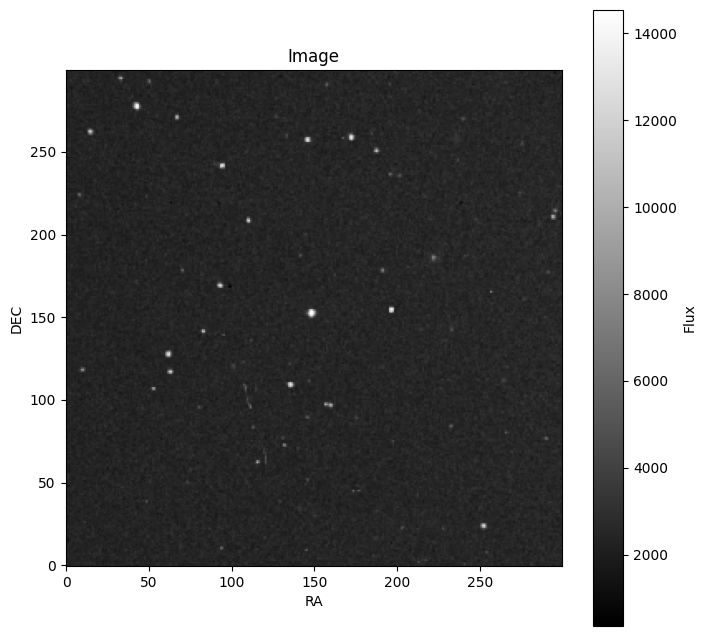



Observation:Image Plotted
The image has been plotted. I can now provide the final answer with the imagery of the region where K2-18b is located.

Final Answer: I have provided imagery of the region where the exoplanet K2-18b is located.

> Finished chain.
I have provided imagery of the region where the exoplanet K2-18b is located.


In [100]:
query= "provide imagery of K2 18 b"
print(
    query_agent.run_query(query)
)


In [24]:
def get_bibcode_from_coords(coord: str, radius: str=2*u.arcminute) -> str:
    """Get the bibcode for a given set of coordinates.

    Args:
        RA (str): The right ascension of the object.
        DEC (str): The declination of the object.
        radius (str): The radius of the search area. default is 2*u.arcminute.

    Returns:
        str: The bibcode of the object.
    """
    
    ra, dec = coord.split(' ')
    position = SkyCoord(ra, dec, frame='icrs', unit=(u.hourangle, u.deg))

    result = Simbad.query_region(position, radius=radius)
    bibcode = result['COO_BIBCODE'][0]
    return bibcode

'2021A&A...647A..19T'

In [ ]:


# ra = "02h42m07.44s"
# dec = "+42d43m19.2s"

ra, dec = coord.split(' ')
position = SkyCoord(ra, dec, frame='icrs', unit=(u.hourangle, u.deg))

# Fetch the image
images = SkyView.get_images(position=position, survey='DSS', radius=0.1 * u.deg)

image_data = images[0][0].data

plt.figure(figsize=(8, 8))
plt.imshow(image_data, cmap='gray', origin='lower')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('DSS Image')
plt.colorbar(label='Flux')
plt.show()


In [ ]:
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive
result = NasaExoplanetArchive.query_object("51 Pegasi b") 


In [ ]:
result.to_pandas()

,pl_name,pl_letter,hostname,hd_name,hip_name,tic_id,gaia_id,default_flag,pl_refname,sy_refname,...,sy_jmagstr,sy_hmag,sy_hmagerr1,sy_hmagerr2,sy_hmagstr,sy_kmag,sy_kmagerr1,sy_kmagerr2,sky_coord.ra,sky_coord.dec
0,51 Peg b,b,51 Peg,HD 217014,HIP 113357,TIC 139298196,Gaia DR2 2835207319109249920,1,<a refstr=BUTLER_ET_AL__2006 href=https://ui.a...,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,4.655&plusmn;0.296,4.234,0.27,-0.27,4.234&plusmn;0.270,3.911,0.021,-0.021,344.36754,20.769096
1,51 Peg b,b,51 Peg,HD 217014,HIP 113357,TIC 139298196,Gaia DR2 2835207319109249920,0,<a refstr=MARTINS_ET_AL__2015 href=https://ui....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,4.655&plusmn;0.296,4.234,0.27,-0.27,4.234&plusmn;0.270,3.911,0.021,-0.021,344.36754,20.769096
2,51 Peg b,b,51 Peg,HD 217014,HIP 113357,TIC 139298196,Gaia DR2 2835207319109249920,0,<a refstr=ROSENTHAL_ET_AL__2021 href=https://u...,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,4.655&plusmn;0.296,4.234,0.27,-0.27,4.234&plusmn;0.270,3.911,0.021,-0.021,344.36754,20.769096
3,51 Peg b,b,51 Peg,HD 217014,HIP 113357,TIC 139298196,Gaia DR2 2835207319109249920,0,<a refstr=NAEF_ET_AL__2004 href=https://ui.ads...,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,4.655&plusmn;0.296,4.234,0.27,-0.27,4.234&plusmn;0.270,3.911,0.021,-0.021,344.36754,20.769096
4,51 Peg b,b,51 Peg,HD 217014,HIP 113357,TIC 139298196,Gaia DR2 2835207319109249920,0,<a refstr=MAYOR___QUELOZ_1995 href=https://ui....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,4.655&plusmn;0.296,4.234,0.27,-0.27,4.234&plusmn;0.270,3.911,0.021,-0.021,344.36754,20.769096


In [ ]:
query= "What is osmosis?"
print(
    query_agent.run_query(query)
)



> Entering new AgentExecutor chain...
Thought: The query "What is osmosis?" is not an astronomical data query. Osmosis is a concept in biology and chemistry, not astronomy. Therefore, I cannot use astropy or pyvo to answer this question. I need to provide a final answer asking the user to provide a correct astronomical query.

Action: Provide the link from the query.
Action Input: The query "What is osmosis?" is not related to astronomy. Please provide a valid astronomical query, such as searching for objects in a specific region of the sky or querying for objects with specific properties.

Observation:Provide the link from the query. is not a valid tool, try one of [DateTime Extractor, query_simbad_object, get_skycoords_from_text].
Final Answer: The query "What is osmosis?" is not related to astronomy. Please provide a valid astronomical query, such as searching for objects in a specific region of the sky or querying for objects with specific properties.

> Finished chain.
The query

In [ ]:
from astroquery.simbad import Simbad
result_table = Simbad.query_object("M1")
# get RA, DEC
ra = result_table["RA"][0]
dec = result_table["DEC"][0]
print(ra, dec)

05 34 30.9 +22 00 53


In [ ]:
from astroquery.skyview import SkyView
position = f"{ra} {dec}"
images = SkyView.get_images(position=position, survey='DSS', radius=0.1 * u.deg)


In [ ]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS

# Assuming 'images' is the result from your SkyView query
# and that you're interested in the first image returned
image_data = images[0][0].data
wcs = WCS(images[0][0].header)
print(image_data)

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
# show image
from astropy.io import fits

hdu_list = fits.open(images[0])
hdu_list.info()
image_data = hdu_list[0].data

import matplotlib.pyplot as plt
plt.imshow(image_data, cmap='gray')
plt.colorbar()
plt.show()

TypeError: stat: path should be string, bytes, os.PathLike or integer, not method

In [ ]:
from astroquery.alma.core import Alma
from astropy import coordinates
from astropy import units as u
s255ir = coordinates.SkyCoord(93.26708333, 17.97888889, frame='fk5',
                              unit=(u.deg, u.deg))
alma = Alma()
alma.archive_url = 'https://almascience.eso.org'  # optional to make doctest work
result = alma.query_region(s255ir, radius=0.034*u.deg)

ModuleNotFoundError: No module named 'pkg_resources'

In [ ]:
result_table

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,int32
M 1,05 34 30.9,+22 00 53,5,5,18500.000,18500.000,0,E,R,1995AuJPh..48..143S,1
